In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
# import standard libraries
import copy
import pickle
import numpy as np
import warnings
warnings.filterwarnings('ignore')
# import third-party libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
# import local libraries

# Load data


In [ ]:
# load data 
#df = pd.read_csv('../data/customers.csv')
df = pd.read_csv('/content/drive/My Drive/ds/customers.csv')

# Data cleaning


In [98]:
# convert column TotalCharges to numeric as done in Problem Set 1
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df = df.dropna(axis = 0, how = 'any')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7032 non-null object
gender              7032 non-null object
SeniorCitizen       7032 non-null int64
Partner             7032 non-null object
Dependents          7032 non-null object
tenure              7032 non-null int64
PhoneService        7032 non-null object
MultipleLines       7032 non-null object
InternetService     7032 non-null object
OnlineSecurity      7032 non-null object
OnlineBackup        7032 non-null object
DeviceProtection    7032 non-null object
TechSupport         7032 non-null object
StreamingTV         7032 non-null object
StreamingMovies     7032 non-null object
Contract            7032 non-null object
PaperlessBilling    7032 non-null object
PaymentMethod       7032 non-null object
MonthlyCharges      7032 non-null float64
TotalCharges        7032 non-null float64
Churn               7032 non-null object
dtypes: float64(2), int64(2), ob

In [ ]:
#Target feature is "Churn"
# Data to plot
sizes = df['Churn'].value_counts(sort = True)
colors = ["grey","purple"] 

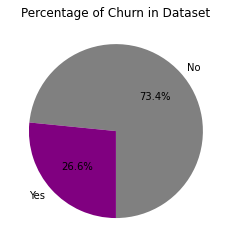

In [100]:
# Plot
plt.pie(sizes, colors=colors,autopct='%1.1f%%', labels = ['No', 'Yes'], shadow=False, startangle=270,)
plt.title('Percentage of Churn in Dataset')
plt.show()

In [101]:
churned = df['Churn'].value_counts()[1]
churned

1869

> Over a quarter of the clients (1869) have churned. We are interested to predict which client will churn in the future based on common features with the ones who have churned so far.

# Feature encoding


In [102]:
# set customerID to index since we are clearly not going to use this as a feature in our models
df = df.set_index('customerID')

# print possibe values for each categorical feature
for col in df:
    if df[col].dtype == 'object':
        print('{}: {}'.format(col, ', '.join(df[col].unique().tolist())))

# customers with no internet service
customers_nointernet = df[df['InternetService'] == 'No'].index

gender: Female, Male
Partner: Yes, No
Dependents: No, Yes
PhoneService: No, Yes
MultipleLines: No phone service, No, Yes
InternetService: DSL, Fiber optic, No
OnlineSecurity: No, Yes, No internet service
OnlineBackup: Yes, No, No internet service
DeviceProtection: No, Yes, No internet service
TechSupport: No, Yes, No internet service
StreamingTV: No, Yes, No internet service
StreamingMovies: No, Yes, No internet service
Contract: Month-to-month, One year, Two year
PaperlessBilling: Yes, No
PaymentMethod: Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic)
Churn: No, Yes


In [ ]:
# check features of customers which have any value == 'No internet services' are the same customers where
# InternetService == 'No'
for col in df:
    if 'No internet service' in df[col].unique().tolist():
        error = customers_nointernet.difference(df[df[col] == 'No internet service'].index)
        assert error.empty # no assert error = good news

# create new column internet with binary values 1 yes, 0 no
df['Internet'] = df['InternetService'].apply(lambda x: 0 if x == 'No' else 1)
# same for DSL / Fiber optic
df['DSL'] = df['InternetService'].apply(lambda x: 1 if x == 'DSL' else 0)
df['FiberOptic'] = df['InternetService'].apply(lambda x: 1 if x == 'Fiber optic' else 0)
# drop useless columns
df = df.drop(columns = 'InternetService')


In [ ]:
# replace features with only two possible values with binary value. We know that if the customer has no 
# internet service then the customer will not have the service feature. The same goes for multiple lines.
binary_map = {'Yes': 1, 'No': 0, 'No internet service': 0, 'No phone service': 0, 'Female': 0, 'Male': 1}
replace_dict = {'gender': binary_map,
                'Partner': binary_map,
                'Dependents': binary_map,
                'PhoneService': binary_map,
                'OnlineSecurity': binary_map,
                'OnlineBackup': binary_map,
                'DeviceProtection': binary_map,
                'TechSupport': binary_map,
                'StreamingTV': binary_map,
                'StreamingMovies': binary_map,
                'PaperlessBilling': binary_map,
                'Churn': binary_map,
                'MultipleLines': binary_map}
df = df.replace(replace_dict, inplace = False)
df = df.rename(columns = {'gender': 'Male'})

In [ ]:
# still need to encode contract and payment method features, we use one hot encoding
dummies = pd.get_dummies(df[['Contract', 'PaymentMethod']], prefix = ['Contract',  'Payment'], prefix_sep = '=')
df = pd.concat([df, dummies], axis = 1)
df = df.drop(columns = ['Contract', 'PaymentMethod'])

for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].astype(int)

In [106]:
# Finished encoding, all dtypes are either int or float
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 27 columns):
Male                                 7032 non-null int64
SeniorCitizen                        7032 non-null int64
Partner                              7032 non-null int64
Dependents                           7032 non-null int64
tenure                               7032 non-null int64
PhoneService                         7032 non-null int64
MultipleLines                        7032 non-null int64
OnlineSecurity                       7032 non-null int64
OnlineBackup                         7032 non-null int64
DeviceProtection                     7032 non-null int64
TechSupport                          7032 non-null int64
StreamingTV                          7032 non-null int64
StreamingMovies                      7032 non-null int64
PaperlessBilling                     7032 non-null int64
MonthlyCharges                       7032 non-null float64
TotalCharges              

# Feature selection


> Features selection allows us to choose the most relevant criterias to determine if a client will churn or not, while discarding any criterias that could lead us to a wrong prediction

In [ ]:
# separate exo/indogenoeous variables
X, y = df.drop(columns = 'Churn'), df[['Churn']]
X_norm = preprocessing.MinMaxScaler().fit_transform(X)

## Recursive selection


In [ ]:
#Allows us to determine the optimal number of features to select for perdiction
selector_rfe = RFECV(estimator=SVC(kernel = 'linear'), cv = StratifiedKFold(10), step = 1)
selector_rfe = selector_rfe.fit(X_norm, y)

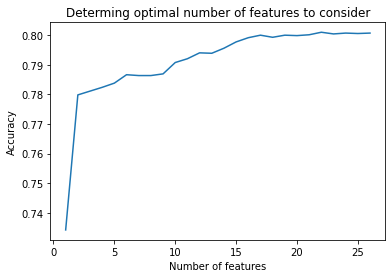

In [111]:
#Show RFE results 
plt.plot(np.arange(1,27), selector_rfe.grid_scores_)
plt.title('Determing optimal number of features to consider')
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.show()

In [ ]:
optimal_number = np.argmax(selector_rfe.grid_scores_)
max_accuracy = selector_rfe.grid_scores_[optimal_number]
mask_rfe = selector_rfe.support_

In [ ]:
#num_feats = optimal_number
num_feats = 7
rfe_feature = X.loc[:,mask_rfe].columns.tolist()

## SelectKBest


In [ ]:
# use the selet k best method from sklearn and evaluate with the chi squared function
X_norm = preprocessing.MinMaxScaler().fit_transform(X)
selector_kbest = SelectKBest(score_func = chi2, k = 'all')
selector_kbest.fit(X_norm, y)
mask_kbest = selector_kbest.get_support()
features_kbest = pd.Series(data = selector_kbest.scores_, index = X.columns)
features_kbest_sorted = features_kbest.sort_values(ascending = False)

chi_feature = features_kbest_sorted.index[:num_feats].tolist()

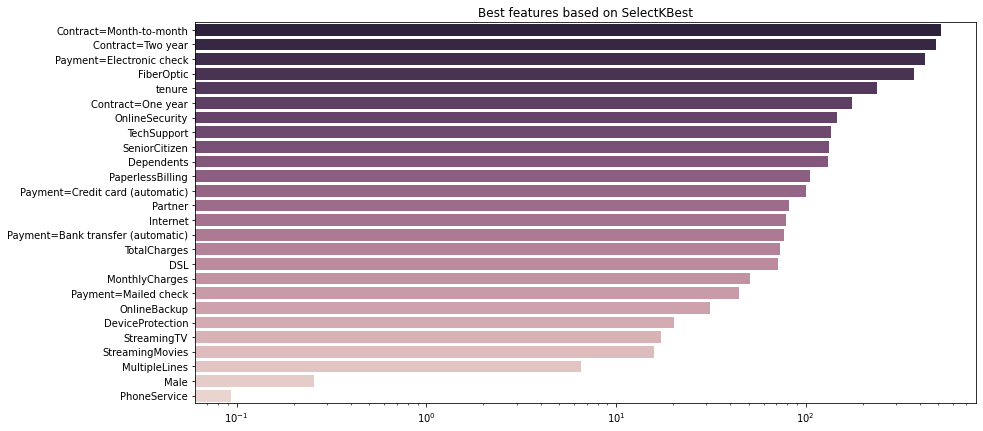

In [115]:
# show features from best to worst (mind the log scale)
fig, ax = plt.subplots(figsize = (14, 7))
_ = sns.barplot(y = features_kbest_sorted.index, x = features_kbest_sorted.values, orient = 'h', ax = ax,
                palette = sns.cubehelix_palette(len(features_kbest), reverse = True))
ax.set_xscale("log")
ax.set_title('Best features based on SelectKBest')
plt.show()


## ExtraTreesClassifier

In [ ]:
# use the extra trees classifire from sklearn
common = 2 #we think that common% of the people who have churned must be in the sample to do deeper in the node of the tree
min_samples_leaf = int(common * churned / 100)
selector_trees_gini = ExtraTreesClassifier(criterion = 'gini', min_samples_leaf = min_samples_leaf)
selector_trees_gini.fit(X, y)
features_trees_gini = pd.Series(data = selector_trees_gini.feature_importances_, index = X.columns)
features_trees_sorted_gini = features_trees_gini.sort_values(ascending = False)

trees_feature_gini = features_trees_sorted_gini.index[:num_feats].tolist()

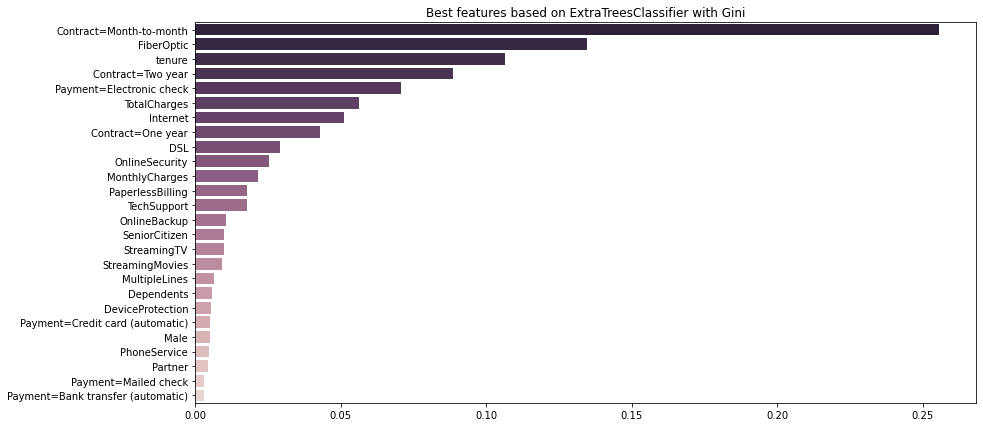

In [117]:
# show features from best to worst
fig, ax = plt.subplots(figsize = (14, 7))
_ = sns.barplot(y = features_trees_sorted_gini.index, x = features_trees_sorted_gini.values, orient = 'h', ax = ax,
                palette = sns.cubehelix_palette(len(features_trees_gini), reverse = True))
ax.set_title('Best features based on ExtraTreesClassifier with Gini')
plt.show()

In [ ]:
# use the extra trees classifire from sklearn
selector_trees_entropy = ExtraTreesClassifier(criterion = 'entropy', min_samples_leaf = min_samples_leaf)
selector_trees_entropy.fit(X, y)
features_trees_entropy = pd.Series(data = selector_trees_entropy.feature_importances_, index = X.columns)
features_trees_sorted_entropy = features_trees_entropy.sort_values(ascending = False)

trees_feature_entropy = features_trees_sorted_entropy.index[:num_feats].tolist()

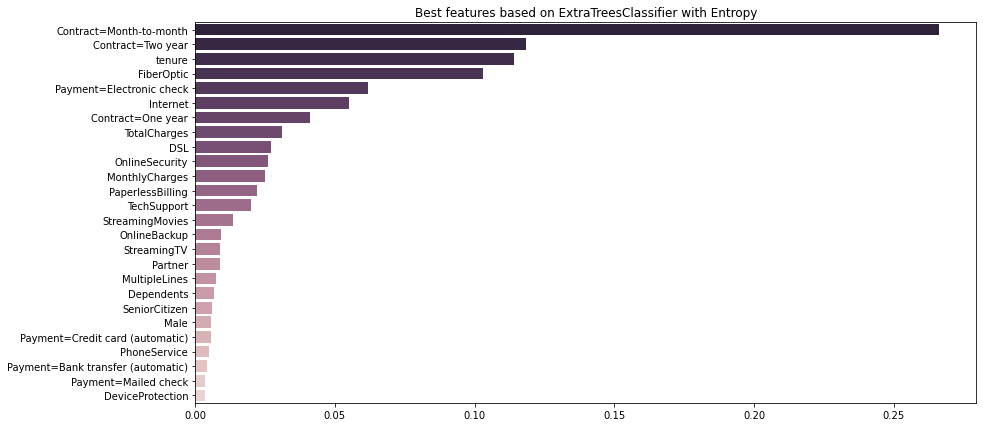

In [119]:
# show features from best to worst
fig, ax = plt.subplots(figsize = (14, 7))
_ = sns.barplot(y = features_trees_sorted_entropy.index, x = features_trees_sorted_entropy.values, orient = 'h', ax = ax,
                palette = sns.cubehelix_palette(len(features_trees_entropy), reverse = True))
ax.set_title('Best features based on ExtraTreesClassifier with Entropy')
plt.show()

## Pearson correlation selection


In [ ]:
def cor_selector(X, y, num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns:
        cor = np.corrcoef(X[i], y.iloc[:,0])[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    
    return cor_support, cor_feature, cor_list

In [145]:
cor_support, cor_feature, cor_list = cor_selector(X, y,num_feats)
best_features_all = set(rfe_feature).intersection(set(chi_feature)).intersection(set(trees_feature_gini)).intersection(set(trees_feature_entropy)).intersection(set(cor_feature))
best_features_all

{'Contract=Month-to-month',
 'Contract=Two year',
 'FiberOptic',
 'Payment=Electronic check',
 'tenure'}

In [ ]:
best_features_all = list(best_features_all)

In [ ]:
## Correlation matrix among all features
corr_matrix_kendall = df.corr('kendall')
corr_matrix_pearson = df.corr()

In [ ]:
# plot heatmap of correelation matrix
fig, ax = plt.subplots(figsize = (20, 20))
ax = sns.heatmap(corr_matrix_kendall, annot = True, cmap = 'Purples')
plt.xticks(rotation = 60)
plt.title('Correlation map with Kendall method')
plt.show()

In [ ]:
# plot heatmap of correelation matrix
fig, ax = plt.subplots(figsize = (20, 20))
ax = sns.heatmap(corr_matrix_pearson, annot = True, cmap = 'Purples')
plt.xticks(rotation = 60)
plt.title('Correlation map with Pearson method')
plt.show()

# Predicting churn

## Scaling the data

In [ ]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range = (0, 1)) # reasonable since most categorial variables are either 0 or 1
min_max_scaler = min_max_scaler.fit(df)
df_min_max = min_max_scaler.transform(df)
df_min_max = pd.DataFrame(data = df_min_max, columns = df.columns, index = df.index)
CV = 7 #choose constant for all methods 

## K-Neighbors classifier

In [ ]:
# define grid parameters to use for gridsearch
param_grid_kneigh = {'weights': ['uniform', 'distance'], 
                       'metric': ['euclidean', 'minkowski'], 
                       'n_neighbors': [2,3,5,7,11,17,23]
                    }

# define the classifier through a gridsearch and tune hyperparameters by cross-validation as well
classifier_kneigh = GridSearchCV(KNeighborsClassifier(algorithm = 'auto'),
                                scoring = 'accuracy',
                                param_grid = param_grid_kneigh,
                                cv = CV
                                )

## Random Tree

In [ ]:
# define grid parameters to use for gridsearch
param_grid_trees = {'max_depth': [1, 5, 10, 50, 100, 200,500],
                    'min_samples_split': [2, 4, 8, 16],
                    'min_samples_leaf': [1, 5, 10, 50, 100, 200],
                    }

# define the classifier through a gridsearch and tune hyperparameters by cross-validation as well
classifier_trees = GridSearchCV(DecisionTreeClassifier(),
                                param_grid = param_grid_trees,
                                scoring = 'accuracy',
                                cv = CV
                                )

## Random Forest

In [ ]:
# define grid parameters to use for gridsearch
param_grid_forest = {'n_estimators': [3,5,10,50,100,150,200],
                     'max_depth': [1, 5, 10, 50],
                     'min_samples_split': [2, 4, 8],
                     'min_samples_leaf': [10, 50, 100, 200],
                     }

# define the classifier through a gridsearch and tune hyperparameters by cross-validation
classifier_forest = GridSearchCV(RandomForestClassifier(),
                                 param_grid = param_grid_forest,
                                 scoring = 'accuracy',
                                 cv = CV
                                 )

## Support Vector Machine 

In [ ]:
# define grid parameters to use for gridsearch
param_grid_svc = {'C': [1, 10, 100, 1000], 
                  'gamma': [0.1, 0.01, 0.001, 0.0001],
                 }

# define the classifier through a gridsearch and tune hyperparameters by cross-validation as well
classifier_svc = GridSearchCV(SVC(kernel = 'rbf'),
                              param_grid = param_grid_svc,
                              scoring = 'accuracy',
                              cv = CV
                              )

## Split train/test set

In [127]:
X_best_all = df_min_max[best_features_all]
X_train_best, X_test_best, y_train_best, y_test_best = train_test_split(X_best_all, y, test_size = 0.2)
X_train_forest_best, X_test_forest_best, y_train_forest_best, y_test_forest_best = train_test_split(df[best_features_all], y, test_size = 0.2)
classifier_kneigh.fit(X_train_best, y_train_best)
classifier_trees.fit(X_train_best, y_train_best)
classifier_forest.fit(X_train_forest_best, y_train_forest_best)
classifier_svc.fit(X_train_best, y_train_best)

GridSearchCV(cv=7, error_score=nan,
             estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                           class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='scale', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [1, 10, 100, 1000],
                         'gamma': [0.1, 0.01, 0.001, 0.0001]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [ ]:
best_score = []
best_score.append(classifier_kneigh.score(X_test_best, y_test_best))
best_score.append(classifier_trees.score(X_test_best, y_test_best))
best_score.append(classifier_forest.score(X_test_forest_best,y_test_forest_best))
best_score.append(classifier_svc.score(X_test_best, y_test_best))

best_index = ['K-Neigh', 'Trees', 'Forest', 'SVC']

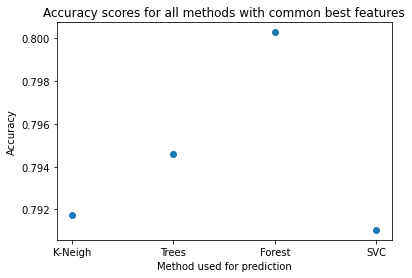

In [131]:
plt.scatter(best_index, best_score)
plt.title('Accuracy scores for all methods with common best features')
plt.ylabel('Accuracy')
plt.xlabel('Method used for prediction')
plt.show()

In [ ]:
# split 80/20 ratio 
score_trees = []
score_forest = []
score_svc = []
score_kneigh = []

#test for all methods 
i = 3
while i < 11: 
    # selection from algorithm
    selected_features_kbest = features_kbest_sorted.index[0:i]
    selected_features_gini = features_trees_sorted_gini.index[0:i]
    selected_features_entropy = features_trees_sorted_entropy.index[0:i]
    
    features = [selected_features_kbest, selected_features_gini, selected_features_entropy, cor_feature]
    for f in features: 
        X_feat_min_max = df_min_max[f]
        X_train, X_test, y_train, y_test = train_test_split(X_feat_min_max, y, test_size = 0.2)
        X_train_forest, X_test_forest, y_train_forest, y_test_forest = train_test_split(df[f], y, test_size = 0.2)
        
        classifier_kneigh.fit(X_train, y_train) 
        classifier_trees.fit(X_train, y_train)
        classifier_forest.fit(X_train_forest, y_train_forest)
        classifier_svc.fit(X_train, y_train)
        
        score_kneigh.append(classifier_kneigh.score(X_test, y_test))
        score_trees.append(classifier_trees.score(X_test, y_test))
        score_forest.append(classifier_forest.score(X_test_forest,y_test_forest))
        score_svc.append(classifier_svc.score(X_test, y_test))
        
    i = i + 1 


In [ ]:
with open('score_svc.pickle', 'wb') as f:
    pickle.dump(score_svc, f)
with open('score_kneigh.pickle', 'wb') as f:
    pickle.dump(score_kneigh, f)
with open('score_trees.pickle', 'wb') as f:
    pickle.dump(score_trees, f)
with open('score_forest.pickle', 'wb') as f:
    pickle.dump(score_forest, f)

In [ ]:
index_selection = ['K-best', 'Tree-Gini', 'Tree-Entropy', 'Pearson Correlation']

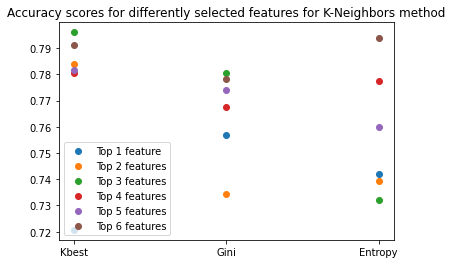

In [91]:
plt.scatter(index_selection, score_kneigh[0:4])
plt.scatter(index_selection, score_kneigh[4:8])
plt.scatter(index_selection, score_kneigh[8:12])
plt.scatter(index_selection, score_kneigh[12:16])
plt.scatter(index_selection, score_kneigh[16:20])
plt.scatter(index_selection, score_kneigh[20:24])
plt.legend(['Top 3 feature', 'Top 4 features', 'Top 5 features', 'Top 6 features', 'Top 7 features', 'Top 8 features'], loc='lower left')
plt.title('Accuracy scores for differently selected features for K-Neighbors method')
plt.ylabel('Accuracy')
plt.xlabel('Method used for features selection')
plt.show()

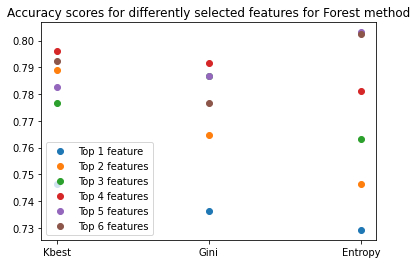

In [92]:
plt.scatter(index_selection, score_forest[0:4])
plt.scatter(index_selection, score_forest[4:8])
plt.scatter(index_selection, score_forest[8:12])
plt.scatter(index_selection, score_forest[12:16])
plt.scatter(index_selection, score_forest[16:20])
plt.scatter(index_selection, score_forest[20:24])
plt.title('Accuracy scores for differently selected features for Forest method')
plt.legend(['Top 3 feature', 'Top 4 features', 'Top 5 features', 'Top 6 features', 'Top 7 features', 'Top 8 features'], loc='lower left')
plt.ylabel('Accuracy')
plt.xlabel('Method used for features selection')
plt.show()

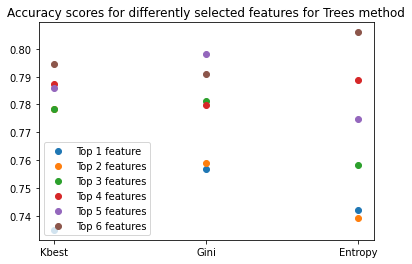

In [93]:
plt.scatter(index_selection, score_trees[0:4])
plt.scatter(index_selection, score_trees[4:8])
plt.scatter(index_selection, score_trees[8:12])
plt.scatter(index_selection, score_trees[12:16])
plt.scatter(index_selection, score_trees[16:20])
plt.scatter(index_selection, score_trees[20:24])
plt.title('Accuracy scores for differently selected features for Trees method')
plt.legend(['Top 3 feature', 'Top 4 features', 'Top 5 features', 'Top 6 features', 'Top 7 features', 'Top 8 features'], loc='lower left')
plt.ylabel('Accuracy')
plt.xlabel('Method used for features selection')
plt.show()

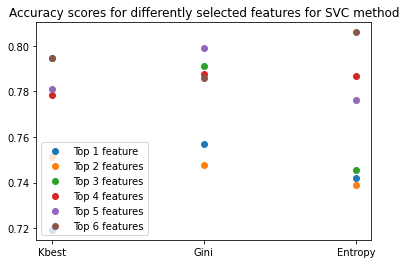

In [94]:
plt.scatter(index_selection, score_svc[0:4])
plt.scatter(index_selection, score_svc[4:8])
plt.scatter(index_selection, score_svc[8:12])
plt.scatter(index_selection, score_svc[12:16])
plt.scatter(index_selection, score_svc[16:20])
plt.scatter(index_selection, score_svc[20:24])
plt.title('Accuracy scores for differently selected features for SVC method')
plt.legend(['Top 3 feature', 'Top 4 features', 'Top 5 features', 'Top 6 features', 'Top 7 features', 'Top 8 features'], loc='lower left')
plt.ylabel('Accuracy')
plt.xlabel('Method used for features selection')
plt.show()